# Approach 2
## Group similar-looking faces across all videos, compute embeddings using MTCNN and FaceNet, cluster them with DBSCAN, and calculate average performance scores from the dataset using OpenCV and PyTorch.

Extracted 6 frames from hd-999607261342550.
Extracted 6 frames from hd-997580728807604.
No faces detected in frame 0. Skipping.
No faces detected in frame 1. Skipping.
No faces detected in frame 2. Skipping.
No faces detected in frame 3. Skipping.
No faces detected in frame 4. Skipping.
No faces detected in frame 5. Skipping.
Extracted 6 frames from hd-992418235673669.
No faces detected in frame 0. Skipping.
No faces detected in frame 4. Skipping.
Extracted 6 frames from hd-992064161877405.
No faces detected in frame 3. Skipping.
No faces detected in frame 4. Skipping.
No faces detected in frame 5. Skipping.
Extracted 6 frames from hd-991636695150147.
Extracted 6 frames from hd-989969399547901.
No faces detected in frame 0. Skipping.
No faces detected in frame 1. Skipping.
No faces detected in frame 2. Skipping.
No faces detected in frame 5. Skipping.
Extracted 6 frames from hd-989930303148492.
No faces detected in frame 0. Skipping.
No faces detected in frame 1. Skipping.
No faces det

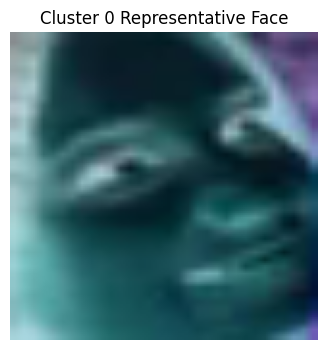

Cluster 1: Average Performance = 0.3103


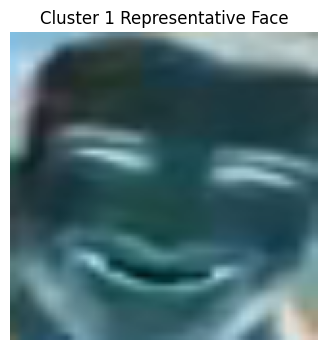

Cluster 2: Average Performance = 0.3103


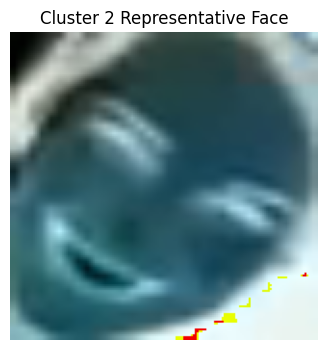

Cluster 3: Average Performance = 1.6774


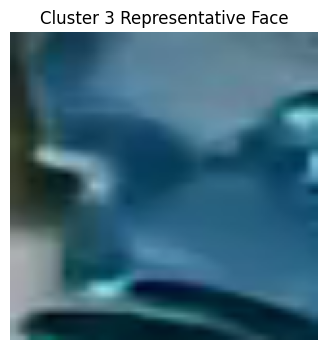

Cluster 4: Average Performance = 0.3934


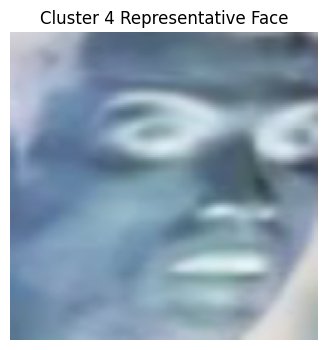

Cluster 5: Average Performance = 0.3934


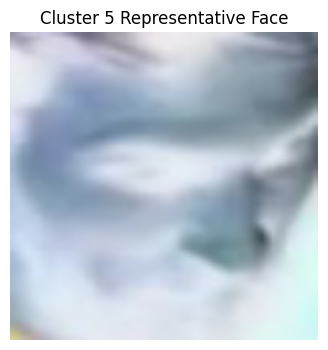

In [15]:
import os
import pandas as pd
import requests
import cv2
import torch
import numpy as np
from sklearn.cluster import DBSCAN
from facenet_pytorch import InceptionResnetV1, MTCNN
import pickle
import matplotlib.pyplot as plt

# Define directories used in my code
video_dir = 'videos'
os.makedirs(video_dir, exist_ok=True)
output_dir = 'extracted_frames'
os.makedirs(output_dir, exist_ok=True)

# Initializing the imported models
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mtcnn = MTCNN(keep_all=True, device=device)  # For face detection
facenet = InceptionResnetV1(pretrained='vggface2').eval().to(device)  # For face embeddings

# Load the dataset
csv_path = '/assignment.csv'
df = pd.read_csv(csv_path)

# Function to download video from URL
def download_video(video_url, save_path):
    print(f"Downloading video from: {video_url}")
    response = requests.get(video_url, stream=True)
    with open(save_path, 'wb') as file:
        for chunk in response.iter_content(chunk_size=1024):
            file.write(chunk)
    print(f"Saved video to: {save_path}")

# Function to extract frames from a video
def extract_frames(video_path, max_frames=5):
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    interval = max(1, frame_count // max_frames)
    frames = []
    for i in range(0, frame_count, interval):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    cap.release()
    return frames

# Function to detect faces and compute embeddings
def process_frames(frames):
    embeddings = []
    faces = []  # To store face images
    for frame_idx, frame in enumerate(frames):
        boxes, _ = mtcnn.detect(frame)
        if boxes is None or len(boxes) == 0:
            print(f"No faces detected in frame {frame_idx}. Skipping.")
            continue

        for x1, y1, x2, y2 in boxes:
            # Ensure bounding box is within frame bounds
            height, width, _ = frame.shape
            x1, y1, x2, y2 = max(0, int(x1)), max(0, int(y1)), min(width, int(x2)), min(height, int(y2))
            face = frame[y1:y2, x1:x2]

            if face.size == 0:
                print(f"Empty face detected in frame {frame_idx}. Skipping.")
                continue

            # Resize to 160x160 for FaceNet to work
            face_resized = cv2.resize(face, (160, 160))
            face_tensor = torch.tensor(face_resized).permute(2, 0, 1).unsqueeze(0).float().to(device) / 255.0
            embedding = facenet(face_tensor).detach().cpu().numpy().squeeze()
            embeddings.append(embedding)
            faces.append(face_resized)  # Store the face image
    return embeddings, faces  # Return both embeddings and faces

# Function to cluster embeddings
def cluster_embeddings(embeddings):
    clustering_model = DBSCAN(eps=0.6, min_samples=2, metric='cosine')
    labels = clustering_model.fit_predict(embeddings)
    return labels, clustering_model

# Main processing loop
def main():
    all_embeddings = []
    performance_scores = []
    all_faces = []  # To store faces corresponding to embeddings
    cluster_scores = {}  # Initialize cluster_scores here
    cluster_faces = {}  # To store one representative face for each cluster

    for _, row in df.iterrows():
        video_url = row['Video URL']
        performance_score = row['Performance']

        video_name = video_url.split('/')[-1]
        video_path = os.path.join(video_dir, video_name)

        # Download video
        if not os.path.exists(video_path):
            download_video(video_url, video_path)

        # Extract frames
        frames = extract_frames(video_path)
        print(f"Extracted {len(frames)} frames from {video_name}.")

        # Process frames and get embeddings
        embeddings, faces = process_frames(frames)
        all_embeddings.extend(embeddings)
        all_faces.extend(faces)

        # Append performance scores for each embedding
        performance_scores.extend([performance_score] * len(embeddings))

    # Cluster embeddings
    print("Clustering embeddings...")
    labels, clustering_model = cluster_embeddings(np.array(all_embeddings))
    unique_clusters = set(labels) - {-1}  # Exclude noise (-1)
    print(f"Found {len(unique_clusters)} unique clusters.")

    # Calculate average scores for each cluster
    for cluster_id in unique_clusters:
        indices = [i for i, label in enumerate(labels) if label == cluster_id]
        cluster_scores[cluster_id] = np.mean([performance_scores[i] for i in indices])

        # Select one representative face from the cluster (First Image)
        representative_face = all_faces[indices[0]]
        cluster_faces[cluster_id] = representative_face

    # Save clustering model
    with open('clustering_model.pkl', 'wb') as f:
        pickle.dump(clustering_model, f)

    # Display results
    print("\nFinal Cluster Performances:")
    for cluster_id, score in cluster_scores.items():
        print(f"Cluster {cluster_id}: Average Performance = {score:.4f}")

        # Save or display the representative face
        representative_face_image = (cluster_faces[cluster_id] * 255).astype(np.uint8)  # Convert back to image format(GAVE NEGATIVE IMAGES ISSUE)
        cv2.imwrite(f'representative_face_cluster_{cluster_id}.jpg', representative_face_image)  # Save the image

        # Display the representative face
        plt.figure(figsize=(4, 4))
        plt.imshow(representative_face_image)
        plt.title(f'Cluster {cluster_id} Representative Face')
        plt.axis('off')
        plt.show()

if __name__ == "__main__":
    main()


Displaying Negative Images of the Images Displayed in Previous Cell:


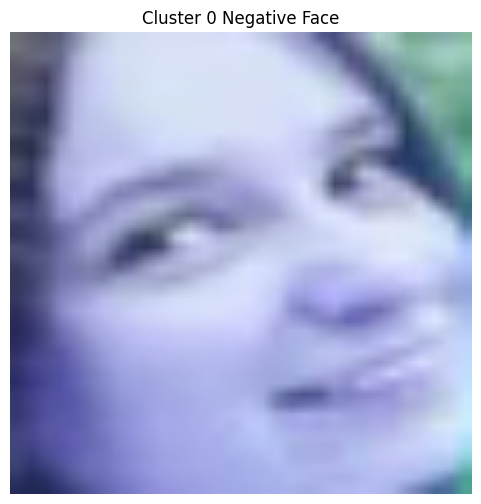

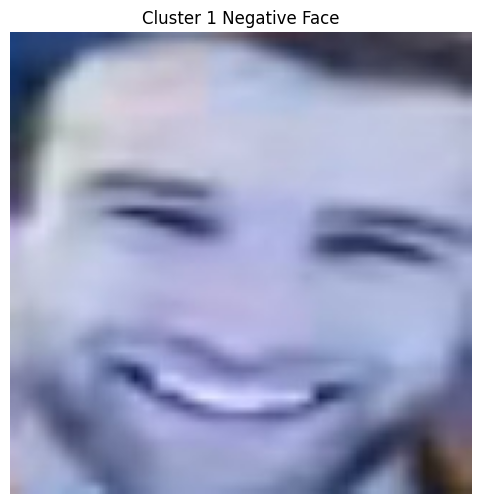

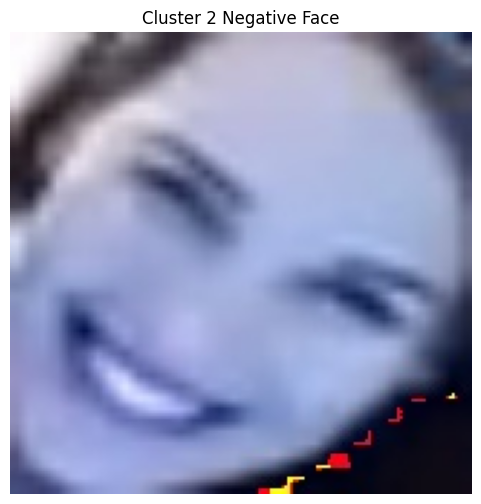

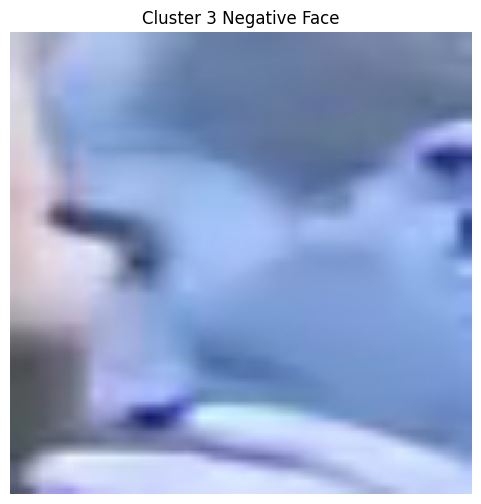

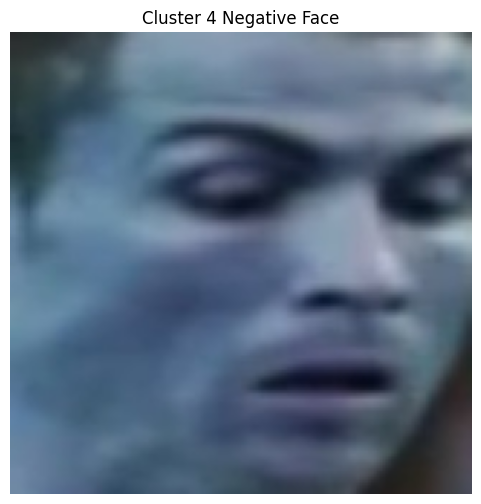

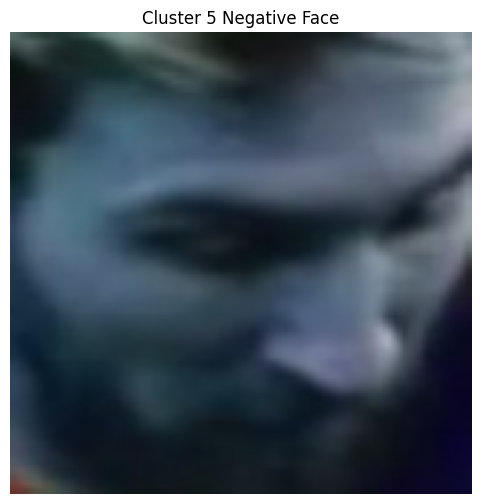

In [21]:
import cv2
import matplotlib.pyplot as plt

cluster_ids = [0, 1, 2, 3, 4, 5]

print("\nDisplaying Negative Images of the Images Displayed in Previous Cell:")
for cluster_id in cluster_ids:
    face_image_path = f'representative_face_cluster_{cluster_id}.jpg'
    face_image = cv2.imread(face_image_path)
    if face_image is not None:
        negative_image = 255 - face_image
        plt.figure(figsize=(6, 6))
        plt.imshow(cv2.cvtColor(negative_image, cv2.COLOR_BGR2RGB))
        plt.title(f'Cluster {cluster_id} Negative Face')
        plt.axis('off')
        plt.show()
    else:
        print(f'Failed to load image for cluster {cluster_id} from {face_image_path}')